In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Data cleaning 
1. Save as csv and load into Pandas
2. Clean up stream times and dates 
3. Remove irrelevant columns 
4. Change stream time in minutes to an int value 

In [3]:
raw_data_0 = pd.read_csv("dazn_experimentation_grad_task.csv")

In [4]:
np.sum(raw_data_0.isna())
# No missing data in time variables, therefore easy to parse 

str_viewer_id                            0
str_playing_time                         0
str_country                              0
str_start_time                           0
str_end_time                             0
str_month                                0
str_total_streaming_time_ms              0
str_engaged_play                         0
str_live_or_on_demand                    0
str_sport_name                         262
str_device_category                    510
str_hd_flag                              0
cust_subscription_term_start_date    14836
cust_test_customer_flag                961
dtype: int64

In [5]:
def parse_datetime(series): 
    date_series = []
    datetime_series = []
    for str_1 in series:
        date, time = str_1.split("T")
        ## Didn't parse miliseconds because I didn't think it was important 
        time = time[:8]
        datetime = date + "-" + time 
        date_series.append(date)
        datetime_series.append(datetime)
    return pd.Series(datetime_series), pd.Series(date_series)

str_datetime_start, str_date_start = parse_datetime(raw_data_0.str_start_time)
# Added a date variable for streaming end, just incase the stream ended the next day
str_datetime_end, str_date_end = parse_datetime(raw_data_0.str_end_time)
        
raw_data = raw_data_0.drop(["str_start_time", "str_end_time", "str_month"], axis = 1)
raw_data["str_date_start"] = pd.to_datetime(str_date_start, format = "%Y-%m-%d")
raw_data["str_datetime_start"] = pd.to_datetime(str_datetime_start, format = "%Y-%m-%d-%H:%M:%S")
raw_data["str_date_end"] = pd.to_datetime(str_date_end, format = "%Y-%m-%d")
raw_data["str_datetime_end"] = pd.to_datetime(str_datetime_end, format = "%Y-%m-%d-%H:%M:%S")
raw_data["str_total_streaming_time_ms"] = raw_data["str_total_streaming_time_ms"].astype(int)



## Which device category has the highest median playing time?
Unknown 

In [6]:
raw_data["str_playing_time"].groupby(raw_data["str_device_category"]).median().sort_values(ascending = False).head(1)

str_device_category
Unknown    125051.0
Name: str_playing_time, dtype: float64

In [7]:
# Weird considering Unknown makes the lowest amount of observations 
raw_data["str_playing_time"].groupby(raw_data["str_device_category"]).count().sort_values(ascending = False)

str_device_category
Living Room    56928
Mobile         41342
Web            10718
Unknown           87
Name: str_playing_time, dtype: int64

## Which hour of the day has the highest absolute minutes streamed ?
20:00

<BarContainer object of 24 artists>

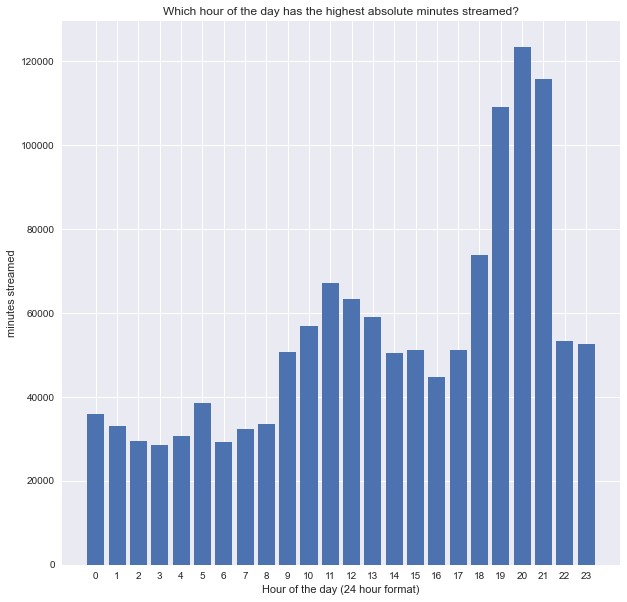

In [9]:
# Initialise dictionary of hour data 
hour_data = {str(i):0 for i in range(24)}
# Get a dataset of just stream hours and minutes 
stream_start = raw_data["str_datetime_start"]
stream_data = pd.DataFrame()
stream_data["hour"] = stream_start.dt.hour
stream_data["min"] = stream_start.dt.minute
stream_data["stream_time"] = raw_data["str_total_streaming_time_ms"] / 60000

# Split problem by if the current stream spills over to the next hours
over = stream_data.query("min + stream_time > 60").copy()
for i in range(over.shape[0]): 
    current_hour = over["hour"].iloc[i]
    current_minute = over["min"].iloc[i]
    stream_time = over["stream_time"].iloc[i]
    mins_to_add = stream_time - (60 - current_minute)
    hour_data[str(int(current_hour))] += (60 - current_minute)
    n_hours = mins_to_add // 60
    for j in range(int(n_hours)): 
        hour_data[str(int((current_hour+1+i)%24))] += 60
    hour_data[str(int((current_hour+1+n_hours)%24))] += mins_to_add % 60
    # Probably overcomplicated it: the code adds spilled minutes from the current hour onto the following hours robustly 
under = stream_data.query("min + stream_time < 60").copy()
dummy = under["stream_time"].groupby(under["hour"]).sum()
for i,j in enumerate(dummy): 
    hour_data[str(i)] += j
    # Minutes of current stream hour are appropriately added 

keys = hour_data.keys()
values = hour_data.values()
plt.style.use('seaborn')
plt.figure(figsize = (10,10))
plt.xlabel("Hour of the day (24 hour format)")
plt.ylabel("minutes streamed")
plt.title("Which hour of the day has the highest absolute minutes streamed?")
plt.bar(keys, values)